In [23]:
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [1]:
!nvidia-smi

Thu Sep 26 11:33:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
import torch
torch.cuda.empty_cache()


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install dependencies

In [3]:
!pip install -q ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.1/874.1 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00


## Imports

In [4]:
from roboflow import Roboflow
from google.colab import userdata
from IPython.display import Image

## Pull dataset

In [11]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(11)
dataset = version.download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.101, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to football-players-detection-11 in yolov8:: 100%|██████████| 756/756 [00:00<00:00, 2880.40it/s]


**NOTE:** Update `data.yaml` structure to align with the latest requirements of the `ultralytics` package.



In [12]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

## Custom training

In [25]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8x.pt data={dataset.location}/data.yaml batch=4 epochs=50 imgsz=1280 plots=True


/content
Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/datasets/football-players-detection-11/data.yaml, epochs=50, time=None, patience=100, batch=4, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

In [29]:
!ls {HOME}/runs/detect/train5/

args.yaml					    R_curve.png		 val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		 val_batch0_pred.jpg
confusion_matrix.png				    results.png		 val_batch1_labels.jpg
events.out.tfevents.1727351999.21d202e187cd.7351.0  train_batch0.jpg	 val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	 val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg	 val_batch2_pred.jpg
labels.jpg					    train_batch3000.jpg  weights
P_curve.png					    train_batch3001.jpg
PR_curve.png					    train_batch3002.jpg


/content


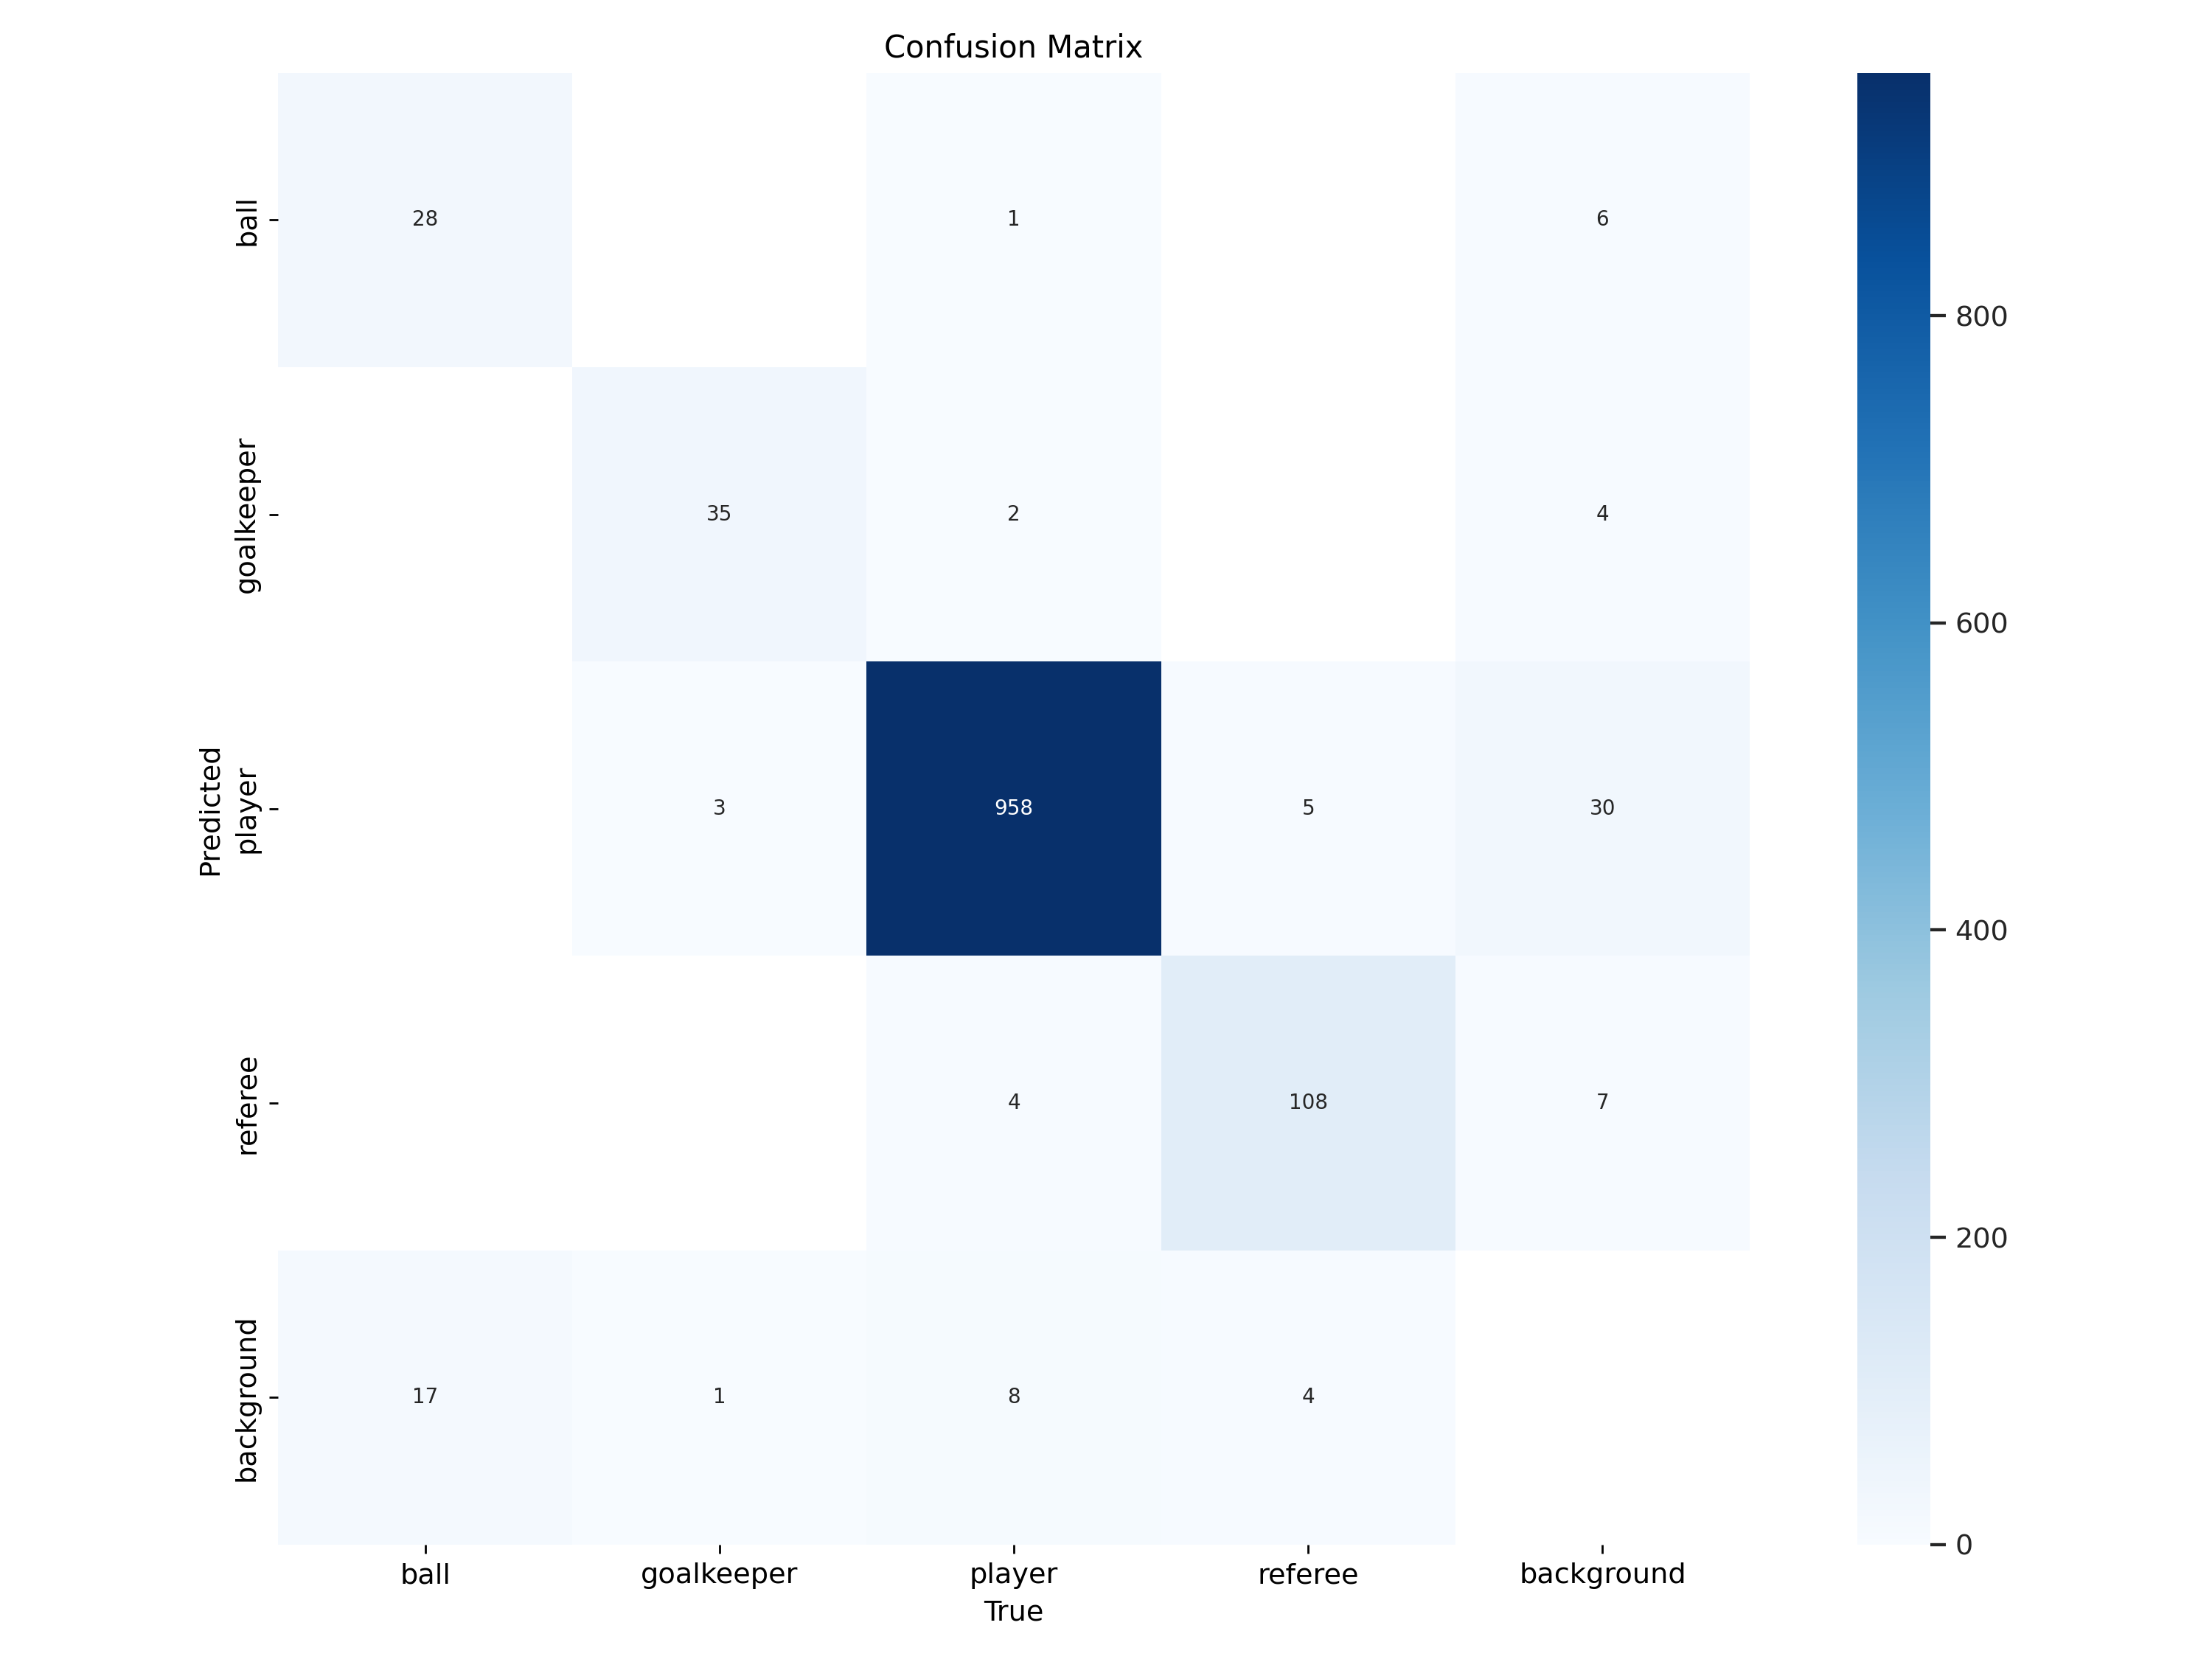

In [30]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train5/confusion_matrix.png', width=600)

/content


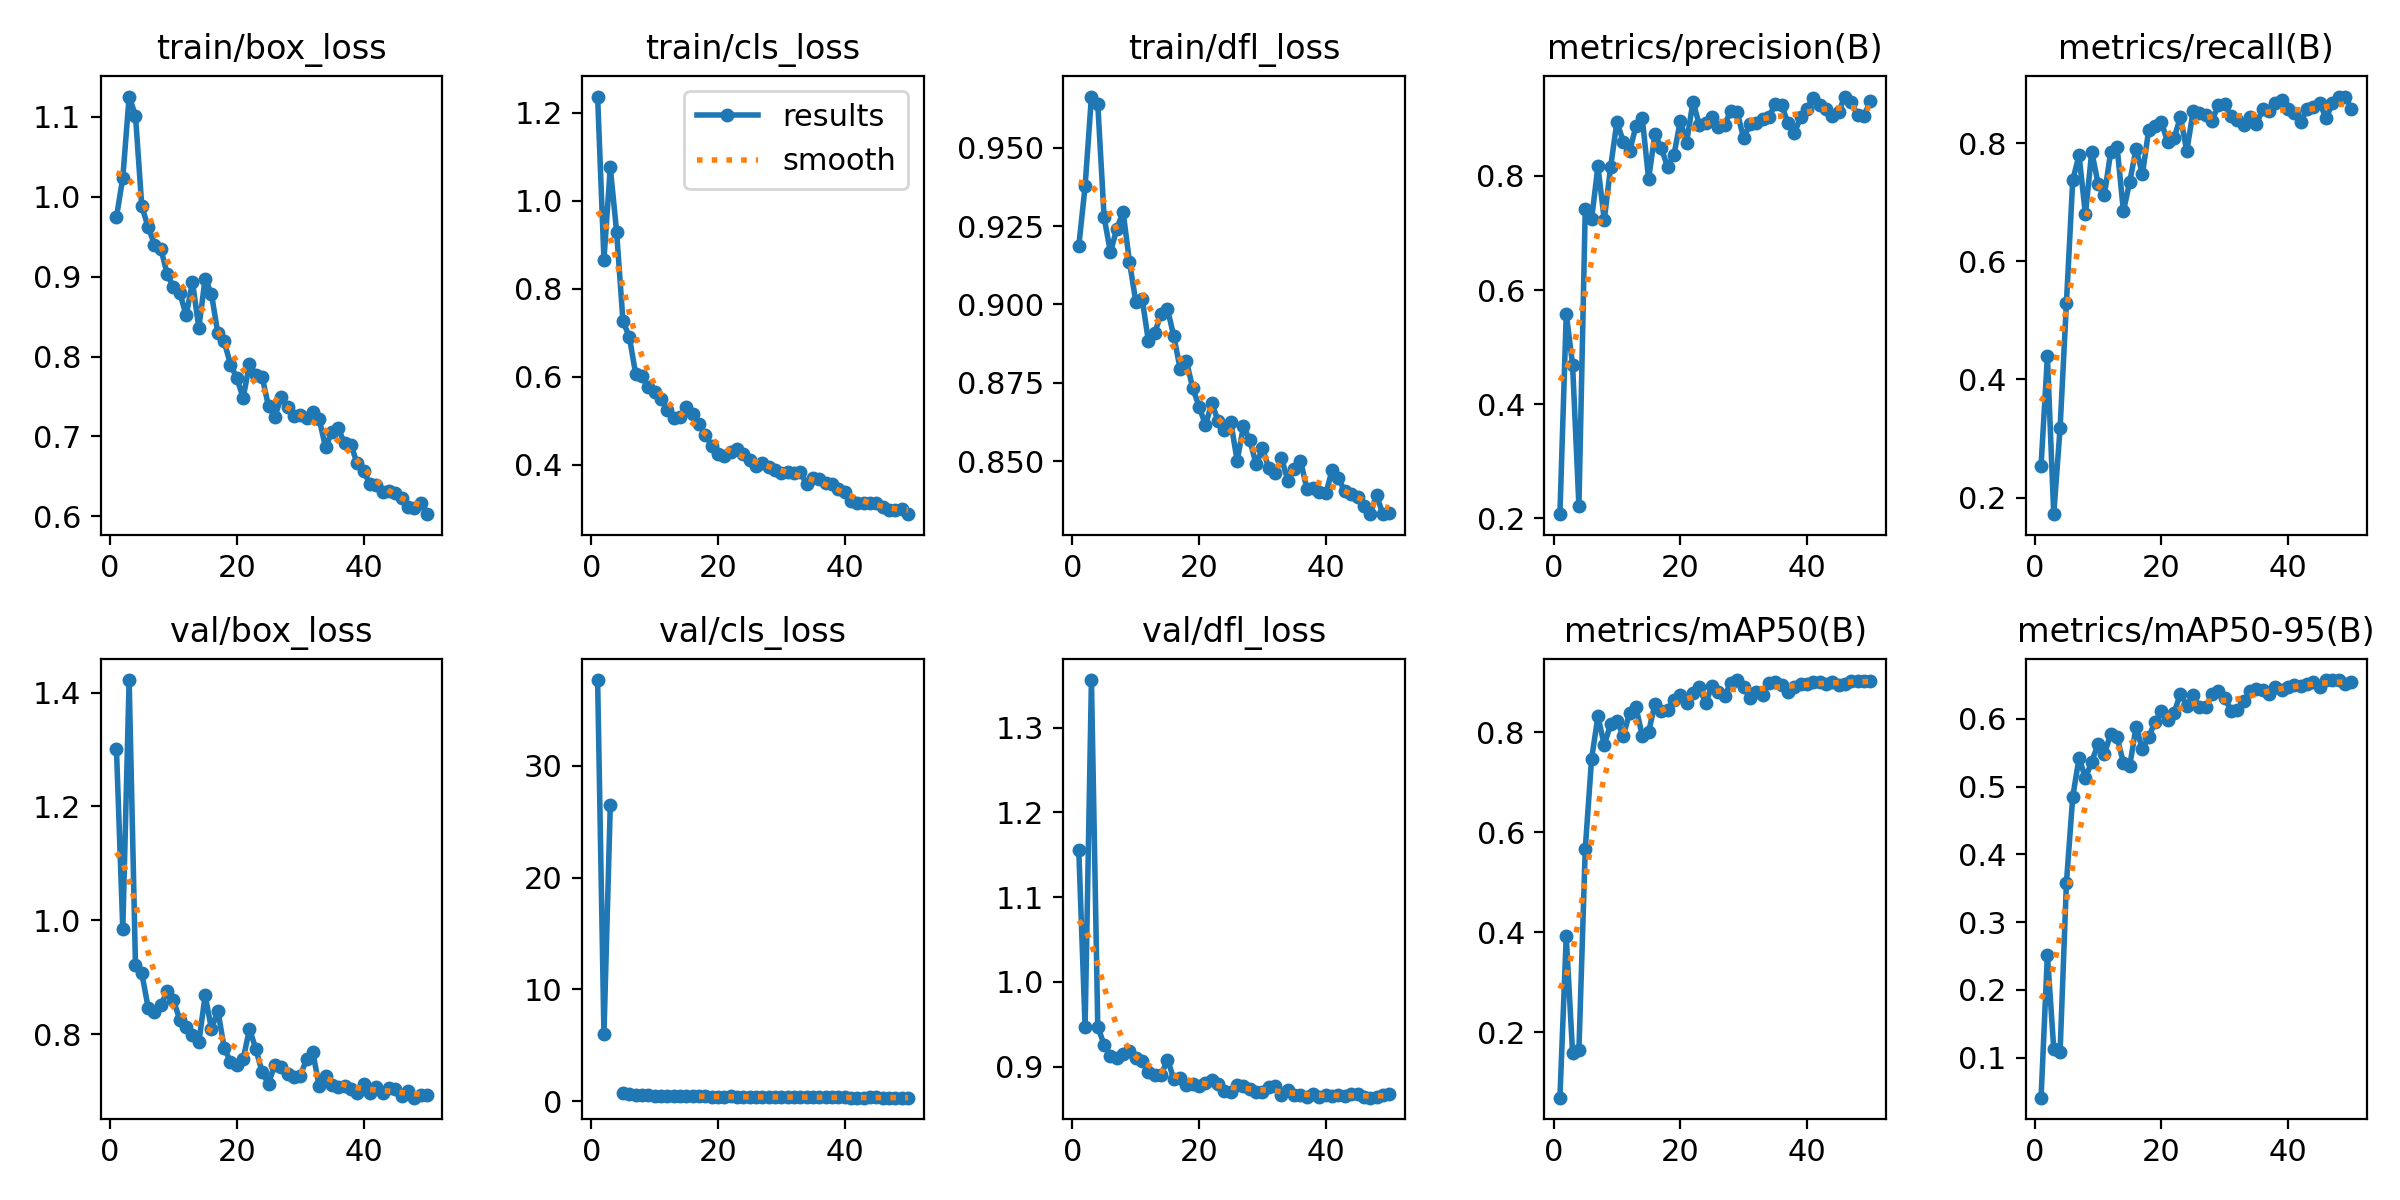

In [31]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train5/results.png', width=600)

/content


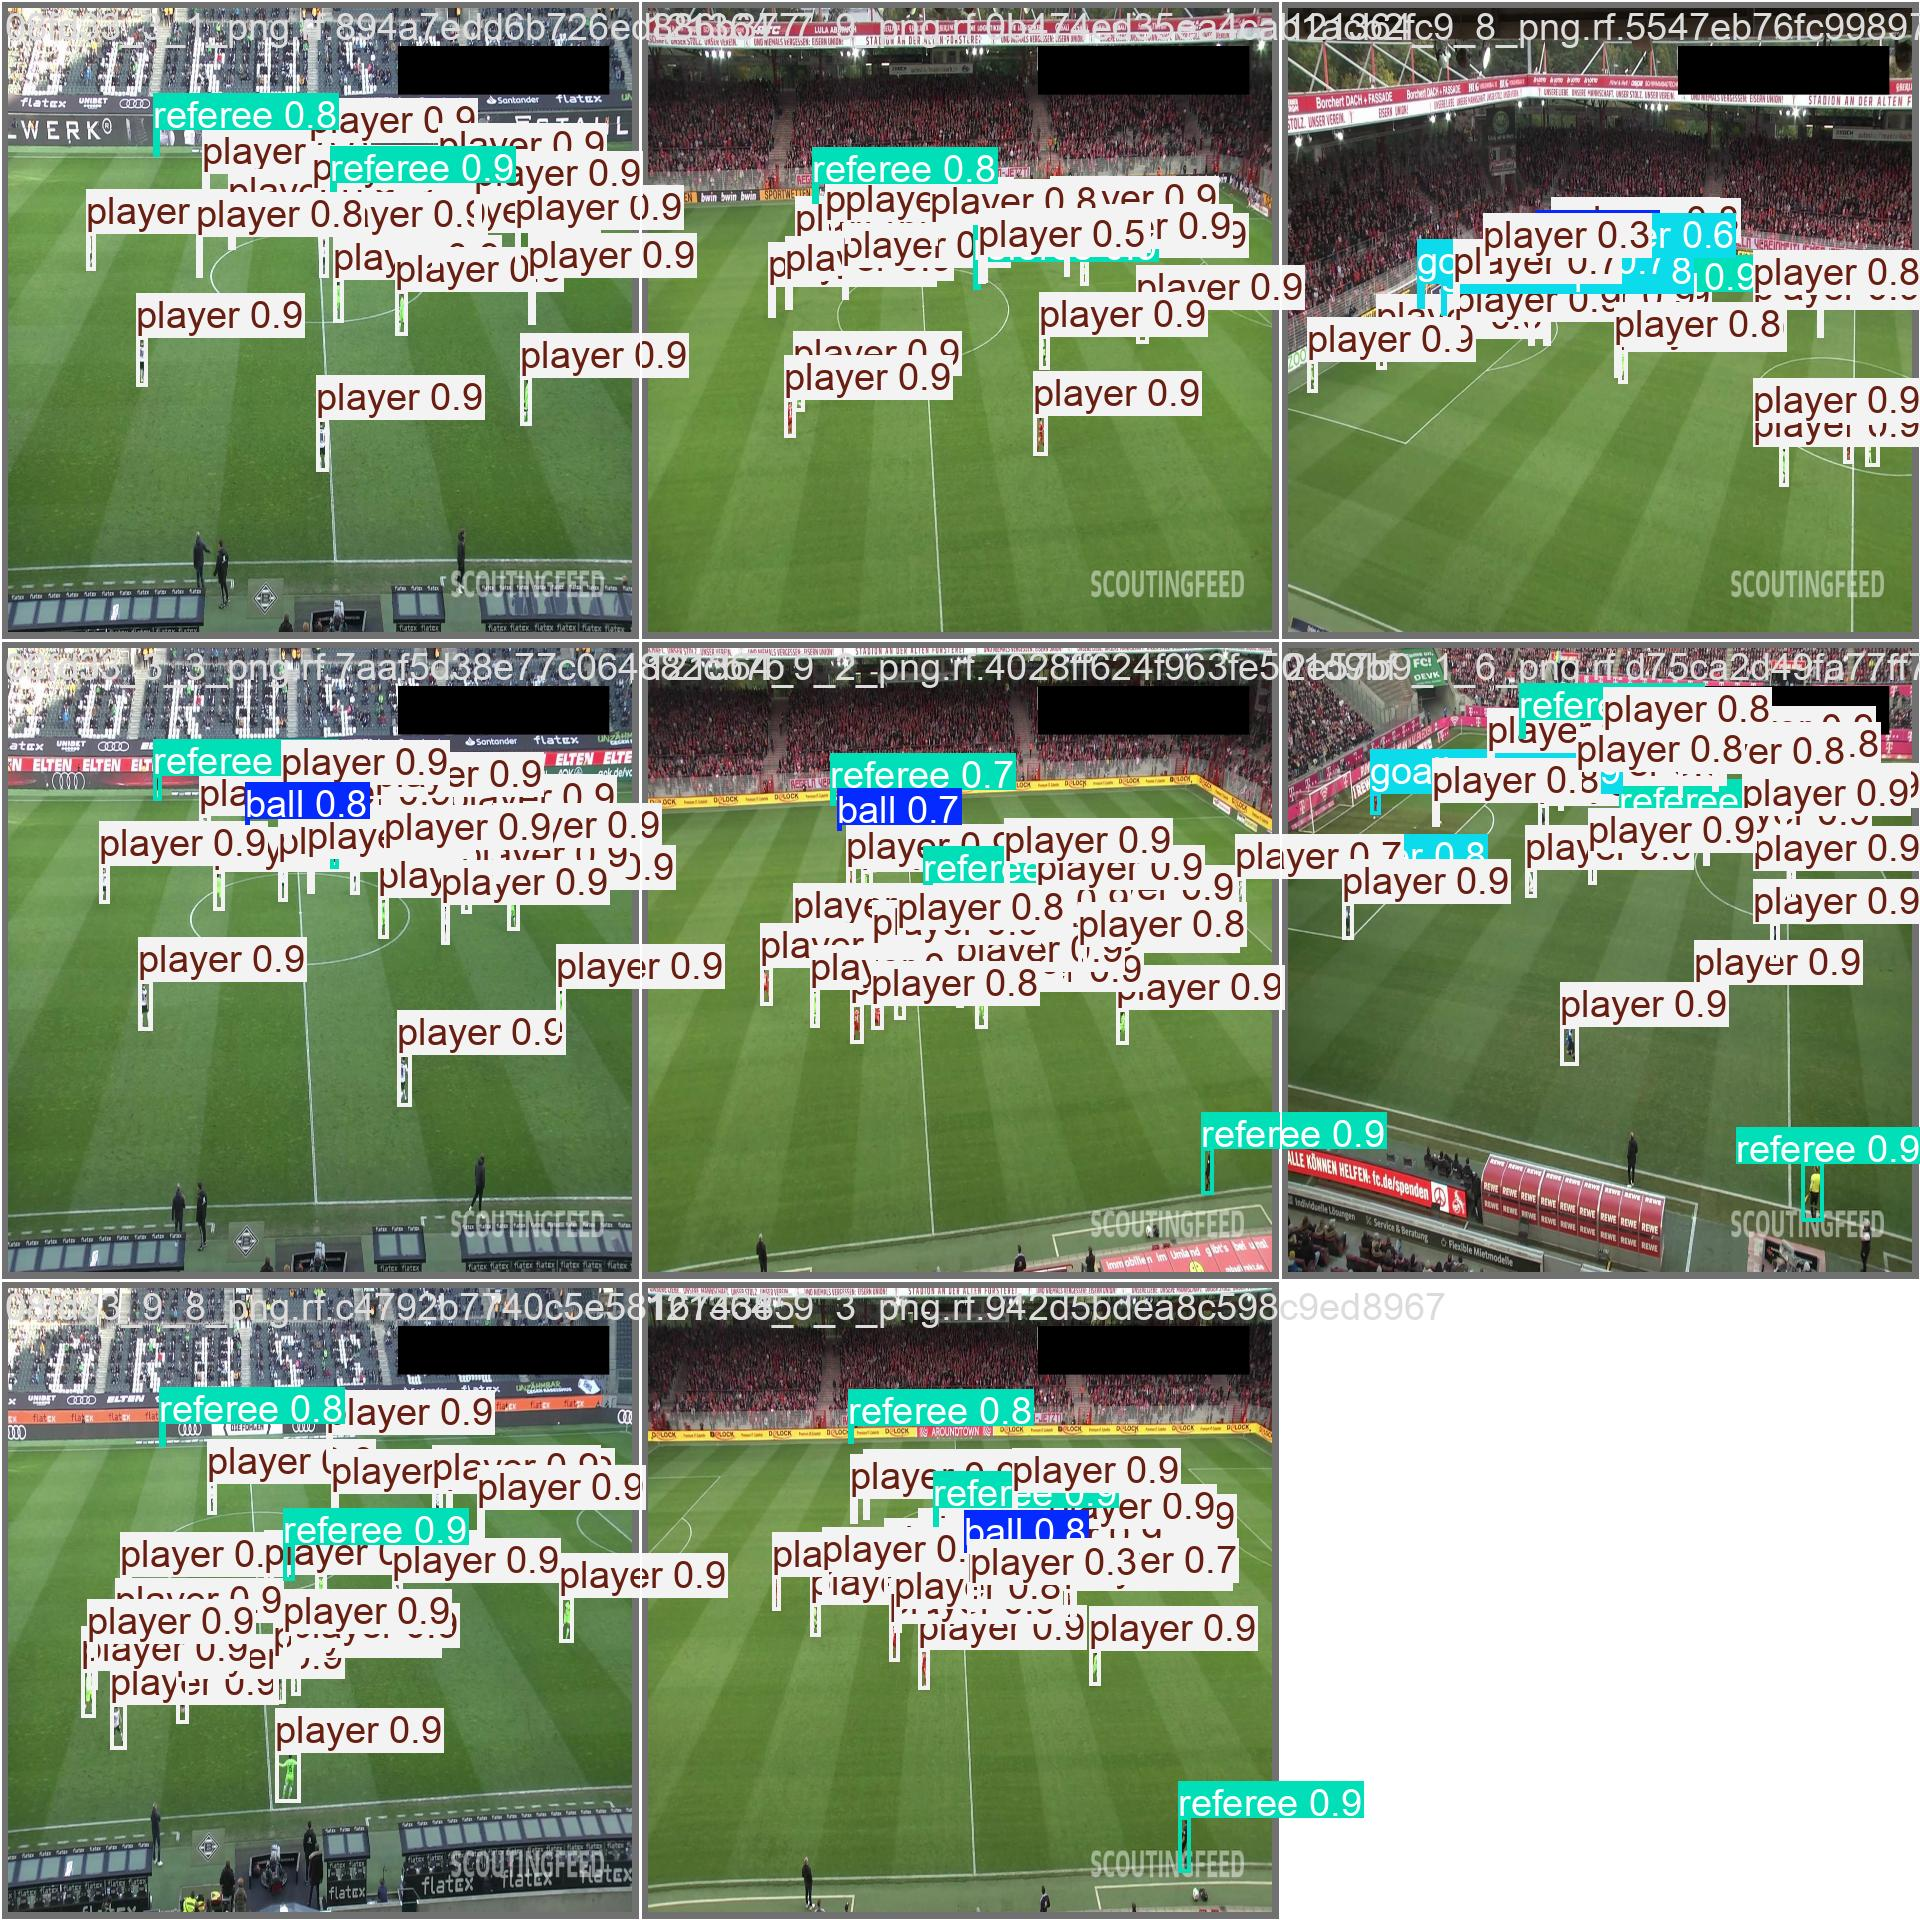

In [32]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train5/val_batch0_pred.jpg', width=600)

## Validate custom model

In [33]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train5/weights/best.pt data={dataset.location}/data.yaml imgsz=1280

/content
Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68,127,420 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /content/datasets/football-players-detection-11/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100% 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:12<00:00,  3.20s/it]
                   all         49       1174      0.916      0.871      0.901       0.66
                  ball         45         45      0.847      0.622      0.689      0.342
            goalkeeper         38         39        0.9      0.923      0.946       0.72
                player         49        973      0.972      0.989      0.994      0.857
               referee         49        117      0.944      0.949      0.975      0.723
Speed: 20.4ms preprocess, 202.5ms inference, 0.0ms loss, 12.3ms postprocess per image
Results saved t

## Deploy model on Roboflow

In [ ]:
project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{HOME}/runs/detect/train5/")

Dependency ultralytics==8.0.196 is required but found version=8.2.101, to fix: `pip install ultralytics==8.0.196`
